In [1]:
#Load in necessary modules and packages.

import os
import numpy as np
import scipy.io.wavfile as sio_wav
import scipy.signal as sp_sig
from filters import (erb_point,erb_space,centre_freqs,make_erb_filters,erb_filterbank,gammatone_analysis,pow_stft,hz2mel,mel2hz,mel_fb,mel_analysis)
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from signal_utils import *
%matplotlib inline
import sounddevice as sd
import scipy.io
from scipy import signal
import keras
from keras.models import model_from_json
# from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from helper_ops import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Main code framework to compare auditory model outputs.
#Sarah Verhulst, Deepak Baby, Arthur Van Den Broucke, UGent, 2021

# General parameters
framelength_t = 0.25 # framelength in time = 250ms
#frameshift_t = 0.01 # frameshift in time = 10ms
L = 70. # specify the desired SPL of the input
fs_GT = 48e3 # GT model 48 kHz
fs_Con = 20e3 # CoNNear model 20 kHz

#Your code to Generate a Pure-tone goes here 
#Take note that the CoNNear model uses a context window of 256 samples at both the entry
#aswell at the end, when making a stimulus, add zero's for 256 samples (20 kHz sampling freq)
#to the stimulus to obtain the same output for the GT as the CoNNear model. 


# f = 440.0  # sine frequency, Hz, may be float
f = 50.0  # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
y_GT = (np.sin(2 * np.pi * np.arange(fs_GT * framelength_t) * f / fs_GT))
y_Con = (np.sin(2 * np.pi * np.arange(fs_Con * framelength_t) * f / fs_Con))

t_GT = np.linspace(0, 0.25, len(y_GT))
t_Con = np.linspace(0, 0.25, len(y_Con))


def concat_hanning(fs, time_ms, signal):

    samp_ms = int(fs / (1000 / time_ms)) # number of samples in that time span (10ms in our case)
    hann_w = np.hanning(samp_ms*2) # hanning window
    win_ones = np.ones((len(signal) - (samp_ms * 2)), dtype=int) # array of ones for the middle section
    concat = np.concatenate([np.concatenate([hann_w[:samp_ms], win_ones]), hann_w[samp_ms:]]) # concatenating halves of the HW to the begining and end of the array of 1s

    return concat 

HWin_GT = concat_hanning(fs_GT, 10, y_GT)
HWin_Con = concat_hanning(fs_Con, 10, y_Con)

mult_GT = np.multiply(y_GT, HWin_GT)
mult_Con = np.multiply(y_Con, HWin_Con)
pad = np.zeros(256)
padded_Con = np.concatenate((pad, HWin_Con, pad), axis=None)

#output = HWin

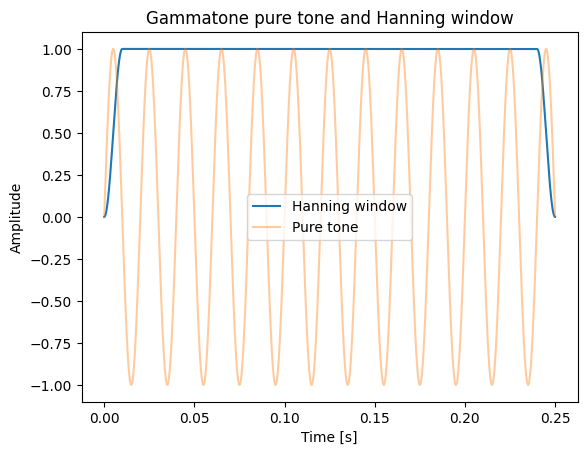

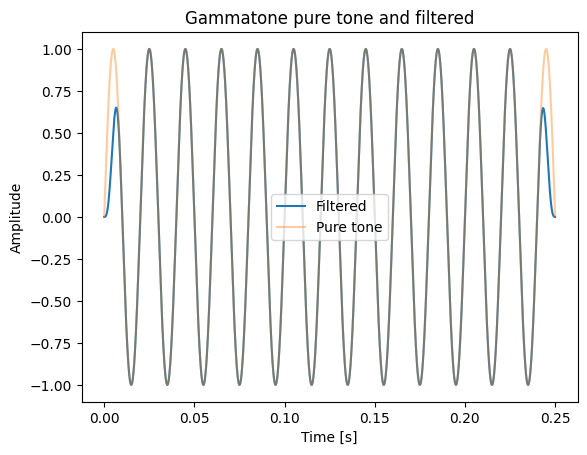

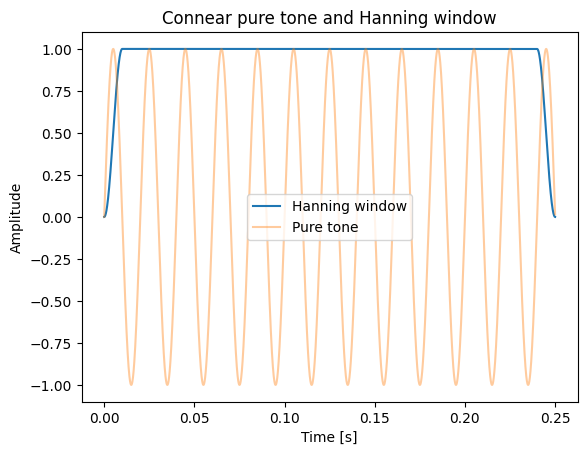

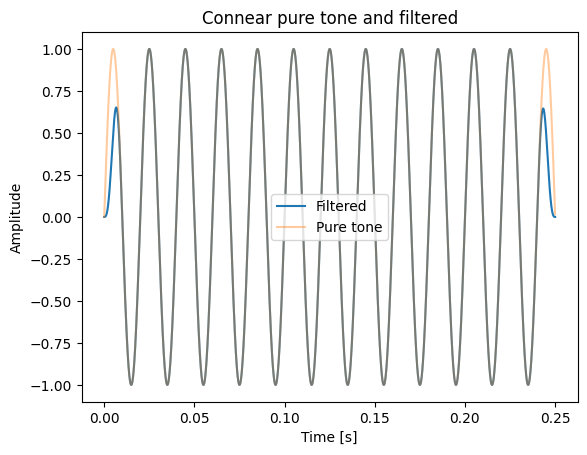

In [3]:
# plotting part of the stimulus
plt.figure(1)
plt.plot(t_GT, HWin_GT, label="Hanning window")
plt.plot(t_GT, y_GT, alpha=0.4, label="Pure tone")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
# plt.xlim((0, 0.02))
plt.title("Gammatone pure tone and Hanning window")
plt.show()

plt.figure(2)
plt.plot(t_GT, mult_GT, label="Filtered")
plt.plot(t_GT, y_GT, alpha=0.4, label="Pure tone")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Gammatone pure tone and filtered")
plt.legend()
# plt.xlim((0, 0.02))

plt.figure(3)
plt.plot(t_Con, HWin_Con, label="Hanning window")
plt.plot(t_Con, y_Con, alpha=0.4, label="Pure tone")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Connear pure tone and Hanning window")
# plt.xlim((0, 0.02))
plt.show()

plt.figure(4)
plt.plot(t_Con, mult_Con, label="Filtered")
plt.plot(t_Con, y_Con, alpha=0.4, label="Pure tone")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Connear pure tone and filtered")
plt.legend()
# plt.xlim((0, 0.02))


# sd.play(y_GT, fs_GT)
# sd.play(mult_GT, fs_GT)
# sd.play(y_Con, fs_Con)
# sd.play(mult_Con, fs_Con)

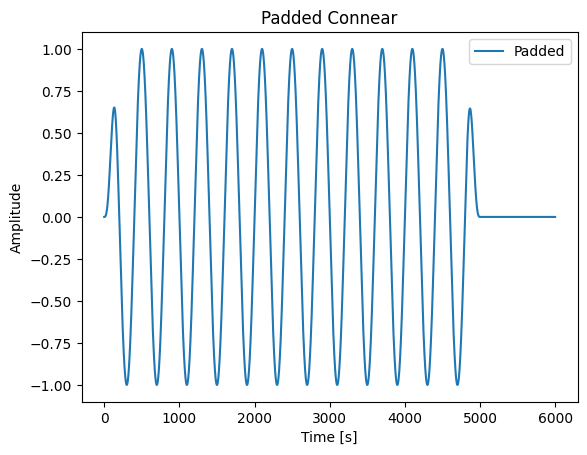

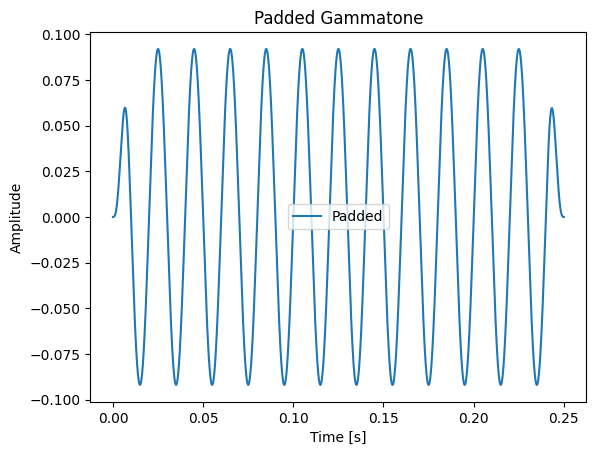

In [17]:
#concatenate the stimulus with some silence afterwards to see model ringdown
silence_Con = np.zeros(int(fs_Con / (1000 / 50))) # + 50ms of 0s for Connear

padded_Con = np.concatenate([mult_Con, silence_Con])
t_pad_Con = np.arange((len(padded_Con))) # time with the 0 padding for Connear


plt.plot(t_pad_Con, padded_Con, label="Padded")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Padded Connear")
plt.legend()
plt.show()

plt.plot(t_GT, mult_GT, label="Padded")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Padded Gammatone")
plt.legend()
plt.show()

In [18]:
##Load in CoNNear model
json_file = open("connear/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()
connear = model_from_json(loaded_model_json)
connear.load_weights("connear/Gmodel.h5")
connear.summary()

mult_GT = adjust_spl(mult_GT, L)
# parameters for gammatone analysis
fmin = 50. #lowest frequency simulated for GT
numbands = 64 #number of GT bands
# fs_Con = 20e3 # CoNNear requires 20kHz

# Parameters for the cochleagram figures
framelength_t = 0.025/4 # framelength in time 
frameshift_t = 0.01/4 # frameshift in time 
#for the GT
framelength_gt = int(framelength_t * fs_GT)
frameshift_gt = int(frameshift_t * fs_GT)

#for the CoNNear model
framelength_Con = int(framelength_t * fs_Con) # framelength_nn = framelength_Con
frameshift_Con = int(frameshift_t * fs_Con)

# Calculate the gammatone model and cochleagrams
gt_out = gammatone_analysis(mult_GT, fs_GT, numbands, fmin)
gt_cochleagram = cochleagram(gt_out['bmm'], framelength_gt, frameshift_gt)
t_gt = np.arange(len(mult_GT)) / fs_GT

# Calculate the CoNNear model and cochleagrams
print("Resampling signal to " + str(fs_Con) + " Hz")
x_Con = sp_sig.resample_poly(mult_GT, fs_Con, fs_GT)
x_Con = np.expand_dims(x_Con, axis=0)
x_Con = np.expand_dims(x_Con, axis=2)
x_Con = x_Con[:, 0:5504, :]
nn_out = connear.predict(x_Con)
nn_out = nn_out[0, :, :]
nn_cochleagram = cochleagram(nn_out.T, int(framelength_t * fs_Con), int(frameshift_t * fs_Con))
# t_Con = np.arange(len(x_Con)) / fs_Con
t_Con = np.arange(x_Con.shape[1]) / fs_Con
# print(f"shape axis 1 of x_Con: {x_Con.shape[1]}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 audio_input (InputLayer)    [(None, None, 1)]         0         
                                                                 
 model_1 (Functional)        (None, None, 201)         11689984  
                                                                 
Total params: 11,689,984
Trainable params: 11,689,984
Non-trainable params: 0
_________________________________________________________________
Resampling signal to 20000.0 Hz


ValueError: in user code:

    File "c:\Users\cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Users\cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 3572, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concatenate_1' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 626 and 625. Shapes are [?,626] and [?,625]. for '{{node model_2/model_1/concatenate_1/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](model_2/model_1/activation_5/Tanh, model_2/model_1/conv1d_3/Conv1D/Squeeze, model_2/model_1/concatenate_1/concat/axis)' with input shapes: [?,626,128], [?,625,128], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concatenate_1' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 626, 128), dtype=float32)', 'tf.Tensor(shape=(None, 625, 128), dtype=float32)']


In [10]:
#The indexes belonging to the 1 kHz frequency channels
#You can modify some parts of this code to see the response to a different CF channel 
Nch,N = np.shape(gt_out['bmm'])
Nch_nn,N_nn= np.shape(nn_out)
Bch_gt = np.nonzero(gt_out['cf']<1000) #get the CF channels with values < 1000 Hz
Bch_gt
Ch1k_gt = int(42)
Ch1k_nn = int(78) # CF channels with values < 1000 Hz for CoNNear

gt = np.zeros((Nch, N)) #copy the data so we can work with it
gt = gt_out['bmm']

nn = np.zeros((Nch_nn, N_nn)) #copy the data so we can work with it
nn = nn_out.T

#get the 1kHz-CF time-domain signal vs energy signal in specific bins
gt_1k = gt[Ch1k_gt,:] #time domain signal gt
nn_1k = nn[Ch1k_nn,:] #gt energy in 1-kHz channel, when used as preprocessing for Machine Hearing

plt.figure()
plt.plot(t_gt, gt_1k/max(gt_1k))
plt.plot(t_Con[:len(nn_1k)], nn_1k/max(nn_1k),'--', alpha=0.4)
plt.legend(['GT','CoNNear'])
#plt.xlim((0.1, 0.12))
plt.show()

NameError: name 'nn_out' is not defined

ValueError: x and y must have same first dimension, but have shapes (64,) and (1,)

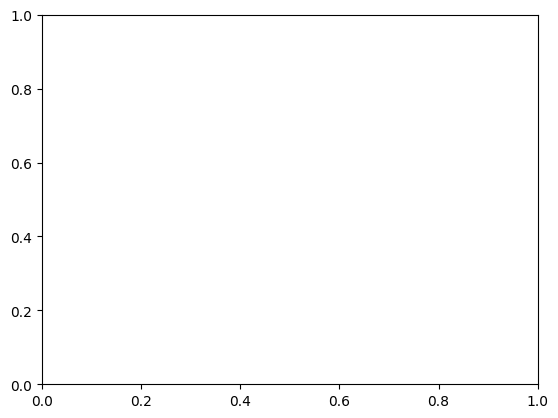

In [8]:
#Generate a cochlear excitation pattern
# 1. get the rms energy of the signals (for each central frequency)
# 2. plot them: x-axis -> central frequencies; y-axis -> RMS value
central_gt = gt_out['cf']
central_nn = []

with open('cf.txt') as f:
    for line in f:
        central_nn.append(float(line))
# central_nn = np.array(central_nn) * 1000 # conn in kHz

def get_rms(freqs):
    suma = np.sum([x**2 for x in freqs])
    RMS = np.sqrt( (1 / (len(freqs))) * suma ) 

    # STILL NEED TO NORMILIZE DIVIDING BY THE MAX VALUE (or the last?)

    return RMS

rms_gt = get_rms(central_gt)
rms_nn = get_rms(central_nn)


plt.plot(central_gt, rms_gt)
plt.title("RMS Gamatone")
plt.xlabel("Central frequencies")
plt.ylabel("RMS")
plt.show()


In [2]:
#Generate a click stimulus C_gt and C_nn: your code goes here
#outputs C_gt and C_nn as well as the time vectors: t_nn and t_gt
#plt.figure()
#plt.plot(t_gt,C_gt)
#plt.plot(t_nn,C_nn)

In [ ]:
#run the stimulus for different levels through the model
L_list=np.arange(10, 100, 10)
Cs_gt=np.zeros((Nch, N_gt, len(L_list)))
Cs_nn=np.zeros((Nch_nn, len(C_nn), len(L_list)))
Ps =np.zeros((N_gt, len(L_list)))

nCh_1k = 42 #to write out the 1-kHz channel, and example is only made for the GT model here
#you should add corresponding code for the CoNNear model
for nL,L in enumerate(L_list):
    x = adjust_spl(C_gt, L)
    result = gammatone_analysis(x, fs, numbands, fmin)
    Cs_gt[:, :, nL] = result['bmm']
    Ps[:, nL] = (2*abs(np.fft.fft(result['bmm'][nCh_1k, :]))/result['bmm'].shape[1])**2

plt.figure()
plt.plot(t_gt, Cs_gt[nCh_1k, :, :])

# Frequency domain
plt.figure()
freq_vect = np.fft.fftfreq(N_gt, d=1/fs)
plt.plot(freq_vect[:int(N_gt/2)], 10*np.log10(Ps[:int(N_gt/2)]))
plt.xlim((0, 8000))